In [1]:
import pandas as pd
import numpy as np

from numpy.linalg import norm
from sklearn.decomposition import PCA

import itertools
import random

import pickle

import matplotlib.pyplot as plt
%matplotlib inline

Extract network features and use them to compute similarity between 20 seeds in the <b>finance domain</b> and <b>random users</b>.

The idea is to keep part of the seeds as seeds and the other part as good candidates, while all the random users are bad candidates. In this way it is possible to assess automatically the goodness of the method, because the groundtruth is already validated.

Steps to follow:
1. Split seeds in candidates and effective seeds (10/10) - <b> define shared list of combinations </b>
2. Compute centroid with effective seeds
3. Rank random users and candidates with respect to the centroid
4. Compute #good candidates extracted at each level of ranking and plot the resulting line against the random ranking (linear)
5. Iterate with different splits
6. Compare with respect to the fingerprint method

In [2]:
# ranking is based on distance similarity
def candidatesRanking(candidates, centroid, features):
    #centroid_v = np.array(centroid[features])
    
    output = pd.DataFrame()
    output['distance'] = candidates.apply(lambda x: norm(np.array(x[features]) - centroid), axis=1)
    output['username'] = candidates['username']
    output['id_user'] = candidates['id_user']
    output['similarity'] = output.apply(lambda x: 1/(1+x['distance']), axis=1)
    #output['link'] = output.apply(lambda x: 'www.twitter.com/'+x['username']+'/', axis=1)
    
    output.sort_values(by='similarity', ascending=False, inplace=True)
    
    # reset_index -> index+1 becomes the ranking
    output.reset_index(inplace=True)
    
    return output

In [3]:
def computeCentroid(seeds, normheader):
    arrays = [np.array(x[normheader]) for index, x in seeds.iterrows()]
    
    return np.sum(arrays, axis=0)/seeds.shape[0]

In [4]:
def cumulativeGoodCandidates(ranking):
    cumulative = []
    n_good_candidates = 0
    
    for index, ranked_user in ranking.iterrows():
        if ranked_user['good'] == True:
            n_good_candidates = n_good_candidates + 1
        cumulative.append(n_good_candidates)
        
    return np.array(cumulative)

In [5]:
def plotData(seeds, candidates, components):
    x = components[0]
    y = components[1]
    
    plt.figure(figsize=(12,12))
    plt.scatter(candidates[x], candidates[y], marker='.', s=40, lw=0, alpha=0.7)
    plt.scatter(seeds[x], seeds[y], marker='x', color='red')

In [6]:
def computeSimDistribution(ranking, float_prec):
    prec_str = '%.{}f'.format(float_prec)
    ranking['truncated'] = ranking.apply(lambda x: float(prec_str%(x['similarity'])), axis=1)
    
    y = ranking.groupby(by='truncated').count().reset_index()[['truncated','similarity']]
    y.columns = ['sim','freq']
    y.sort_values(by='sim', inplace=True)
    
    return y

In [7]:
header = ['{}'.format(i) for i in range(1,9)]

In [8]:
domain = 'finance_20'
path = '{}/random-test/'.format(domain)
datapath = 'data-seed/{}/'.format(domain)
randompath = 'data-random/'

## List of members/candidates combinations

Generate the combinations of ids to be used as actual members (the others are the good candidates by set difference)

In [ ]:
allseeds = map(str, list(pd.read_csv(datapath+'/user.csv', sep='\t')['id_user']))
len(allseeds)

In [ ]:
N = 10
all_combinations = list(itertools.combinations(allseeds, N))
print len(all_combinations)

In [ ]:
shared_combinations = random.sample(all_combinations, 100)

In [ ]:
with open('../all_members_list.pkl', 'w') as alldata:
    pickle.dump(allseeds, alldata)
with open('../combinations.pkl', 'w') as currdata:
    pickle.dump(shared_combinations, currdata)

## Nouns Network Test

In [9]:
allseeds = pickle.load(open('../all_members_list.pkl', 'r'))
combinations = pickle.load(open('../combinations.pkl', 'r'))

In [10]:
allseeds

['36361027',
 '104952689',
 '35810531',
 '6361512',
 '31137628',
 '18622869',
 '241709263',
 '397489668',
 '18378349',
 '327577091',
 '7517052',
 '1305698738',
 '22522178',
 '372460791',
 '300868924',
 '211106542',
 '575160556',
 '407347022',
 '36499730',
 '57268394']

In [12]:
len(combinations)

100

In [14]:
seed_data = pd.read_csv(datapath+'/user.csv', sep='\t')

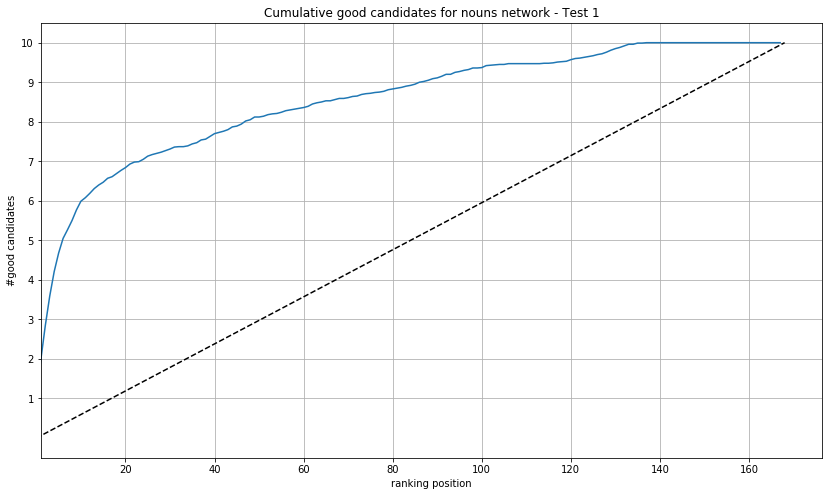

In [15]:
domain = 'finance_20'
path = '{}/random-test/test-network-features/'.format(domain) 

for test in [1]:
    # store the retrieval position of each seed
    candidates_ranking = {}
    for u in allseeds:
        candidates_ranking[u] = []
        
    # features file reading and metadata inclusion
    userdata = pd.read_csv(path+'noun_network_{}_nodes.csv'.format(test), sep='\t') # match graph id and user instance
    data = pd.read_csv(path+'user_features_w_{}.emb'.format(test), sep=' ', header=None, skiprows=1)
    data = userdata.merge(data, left_on='id', right_on=0)
    data.drop(0, inplace=True, axis=1)
    data.columns = ['id_graph','id_user','username','usertype']+header

    data = data[data['usertype'].isin(['seed','user'])]
    data.reset_index(inplace=True)
    
    ysum = np.zeros(data.shape[0] - 10)
    #alldistr = pd.DataFrame(columns=['sim','freq'])

    for seeds in combinations:
        effective_seeds = list(seeds)
        good_candidates = list(set(allseeds)-(set(effective_seeds)))

        seedsVectors = data[data['id_user'].isin(effective_seeds)]
        centroid = computeCentroid(seedsVectors, header)
        candidates = data[~data['id_user'].isin(effective_seeds)]

        r = candidatesRanking(candidates, centroid, header)
        r['good'] = r.apply(lambda x: True if x['id_user'] in good_candidates else False, axis=1)
        y = cumulativeGoodCandidates(r)
        ysum = ysum + y
        
        for index, candidate in r[r['good'] == True].iterrows():
            id_user = candidate['id_user']
            candidates_ranking[id_user].append(index+1)

        #sim_distr = computeSimDistribution(r, 3)
        #alldistr = pd.concat([alldistr, sim_distr])

    y_avg = ysum.astype(float)/len(combinations)
    
    plt.figure(figsize=(14,8))
    plt.title('Cumulative good candidates for nouns network - Test {}'.format(test))
    plt.ylabel('#good candidates')
    plt.xlabel('ranking position')

    plt.plot(y_avg)
    plt.plot([0, len(y_avg)],[0, 10], linestyle='--', color='black')
    plt.xlim(xmin=1)

    plt.yticks(range(1,11))
    plt.grid(True)

In [16]:
for id_user in candidates_ranking:
    print seed_data[seed_data['id_user'] == int(id_user)]['screen_name'].values[0], np.mean(candidates_ranking[id_user])

eu_eurostat 55.1666666667
fgoria 15.8596491228
laurenlacapra 2.69811320755
dsquareddigest 14.9322033898
howardlindzon 11.7058823529
keithmccullough 39.0163934426
queen_europe 4.65957446809
reinman_mt 85.387755102
lamonicabuzz 36.8039215686
faulljonathan 85.9268292683
kathylienfx 7.48571428571
justinwolfers 2.62903225806
ezraklein 6.0652173913
rencapman 9.5625
economistmeg 1.08333333333
bill_easterly 7.07317073171
firoozye 5.88235294118
reformedbroker 1.66666666667
katie_martin_fx 1.9347826087
economisthulk 127.923076923


In [17]:
for id_user in candidates_ranking:
    print id_user, candidates_ranking[id_user]

300868924 [63, 42, 72, 50, 50, 50, 25, 88, 50, 92, 60, 57, 41, 86, 93, 48, 53, 64, 17, 50, 32, 48, 38, 50, 63, 38, 62, 57, 65, 74, 47, 82, 26, 20, 61, 47, 47, 27, 65, 36, 54, 77, 45, 69, 93, 49, 73, 52]
6361512 [22, 7, 26, 14, 3, 3, 15, 30, 25, 26, 42, 29, 23, 18, 14, 2, 21, 12, 13, 12, 15, 19, 24, 6, 10, 5, 26, 7, 31, 22, 11, 9, 15, 14, 19, 7, 5, 19, 6, 4, 16, 8, 17, 5, 40, 10, 19, 10, 2, 11, 4, 9, 30, 21, 30, 32, 9]
36361027 [3, 2, 2, 1, 3, 3, 2, 2, 3, 3, 3, 4, 3, 2, 4, 3, 3, 2, 3, 1, 3, 2, 1, 2, 3, 5, 3, 4, 3, 2, 2, 2, 1, 4, 3, 3, 2, 2, 3, 3, 3, 3, 4, 3, 2, 3, 4, 2, 3, 4, 1, 4, 2]
211106542 [17, 48, 8, 5, 12, 13, 10, 13, 17, 8, 4, 6, 19, 11, 13, 20, 12, 15, 37, 44, 9, 5, 5, 23, 7, 18, 7, 13, 15, 22, 8, 11, 22, 6, 11, 37, 27, 8, 31, 6, 7, 20, 4, 11, 6, 5, 25, 29, 22, 16, 7, 7, 21, 14, 7, 22, 15, 10, 10]
7517052 [25, 27, 4, 6, 8, 6, 26, 18, 13, 3, 16, 28, 6, 17, 5, 4, 11, 4, 10, 15, 4, 14, 5, 32, 4, 10, 28, 10, 14, 17, 39, 6, 9, 10, 13, 5, 15, 7, 7, 15, 5, 10, 7, 8, 5, 5, 8, 4, 20, 6,